In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import expipe
import os
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm
import pandas as pd

sys.path.append('../ca2-mec') if '../ca2-mec' not in sys.path else None 
import dataloader as dl
from utils import *

In [3]:
project = expipe.get_project(dl.project_path())
project.actions

In [4]:
lim = [0,1200] # limit recording times - in seconds
include_actions = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6'] # choose actions to include
#include_actions = ['001-280721-1', '001-280721-2', '001-280721-3', '001-280721-4', '001-280721-5'] #Maria sine opptak fra MEC
#include_actions = ['002-050721-1', '002-050721-2', '002-050721-3', '002-050721-4', '002-050721-5'] #Maria sine opptak fra MEC

spikes = []
tracking = {}
for action_id in include_actions:
    spikes += dl.load_spiketrains(action_id, lim=lim, identify_neurons=True)
    tracking[action_id] = dl.load_tracking(action_id, lim=lim, ca2_transform_data=True) # only get positions

spikes = dl.correct_mua(spikes, only_good_mua=True)
print("Total number of units:", len(spikes))
spatial_map = sp.SpatialMap()

Total number of units: 123


### Compute autocorrelation for every unit

In [5]:
def partial_ratemap_fn(tracking,spike_train,t_mid=600):
    # Divide spikes in intervals [t_start,t_mid] and [t_mid,t_end]
    spike_scope1 = spike_train[spike_train <= t_mid]
    spike_scope2 = spike_train[spike_train > t_mid]
    # compute ratemaps for each scope separately
    x,y,t,_ = tracking[spike_train.annotations["action_id"]].T
    ratemap1 = spatial_map.rate_map(x,y,t,spike_scope1)
    ratemap2 = spatial_map.rate_map(x,y,t,spike_scope2)
    return ratemap1,ratemap2

In [6]:
t_mid=600
stability = {spike_train.annotations["trial_id"] : [] for spike_train in spikes} # empty list for each trial tag
for spike_train in spikes: 
    ratemap1,ratemap2 = partial_ratemap_fn(tracking,spike_train,t_mid)
    # add calculated autocorrelation to neo spike_train annotations
    autocorr = nancorrcoef(ratemap1,ratemap2)
    spike_train.annotations["autocorr"] = autocorr # save in neo spike_train annotations
    stability[spike_train.annotations["trial_id"]].append(autocorr)

### Plot (violin) and summarise statistics (Mann-U)

t1 vs t2: MannwhitneyuResult(statistic=305.0, pvalue=0.1387917384236097)
t1 vs t3: MannwhitneyuResult(statistic=232.0, pvalue=0.6573026199800791)
t1 vs t4: MannwhitneyuResult(statistic=349.0, pvalue=0.27086781429385753)
t1 vs t5n: MannwhitneyuResult(statistic=386.0, pvalue=0.03402030558423712)


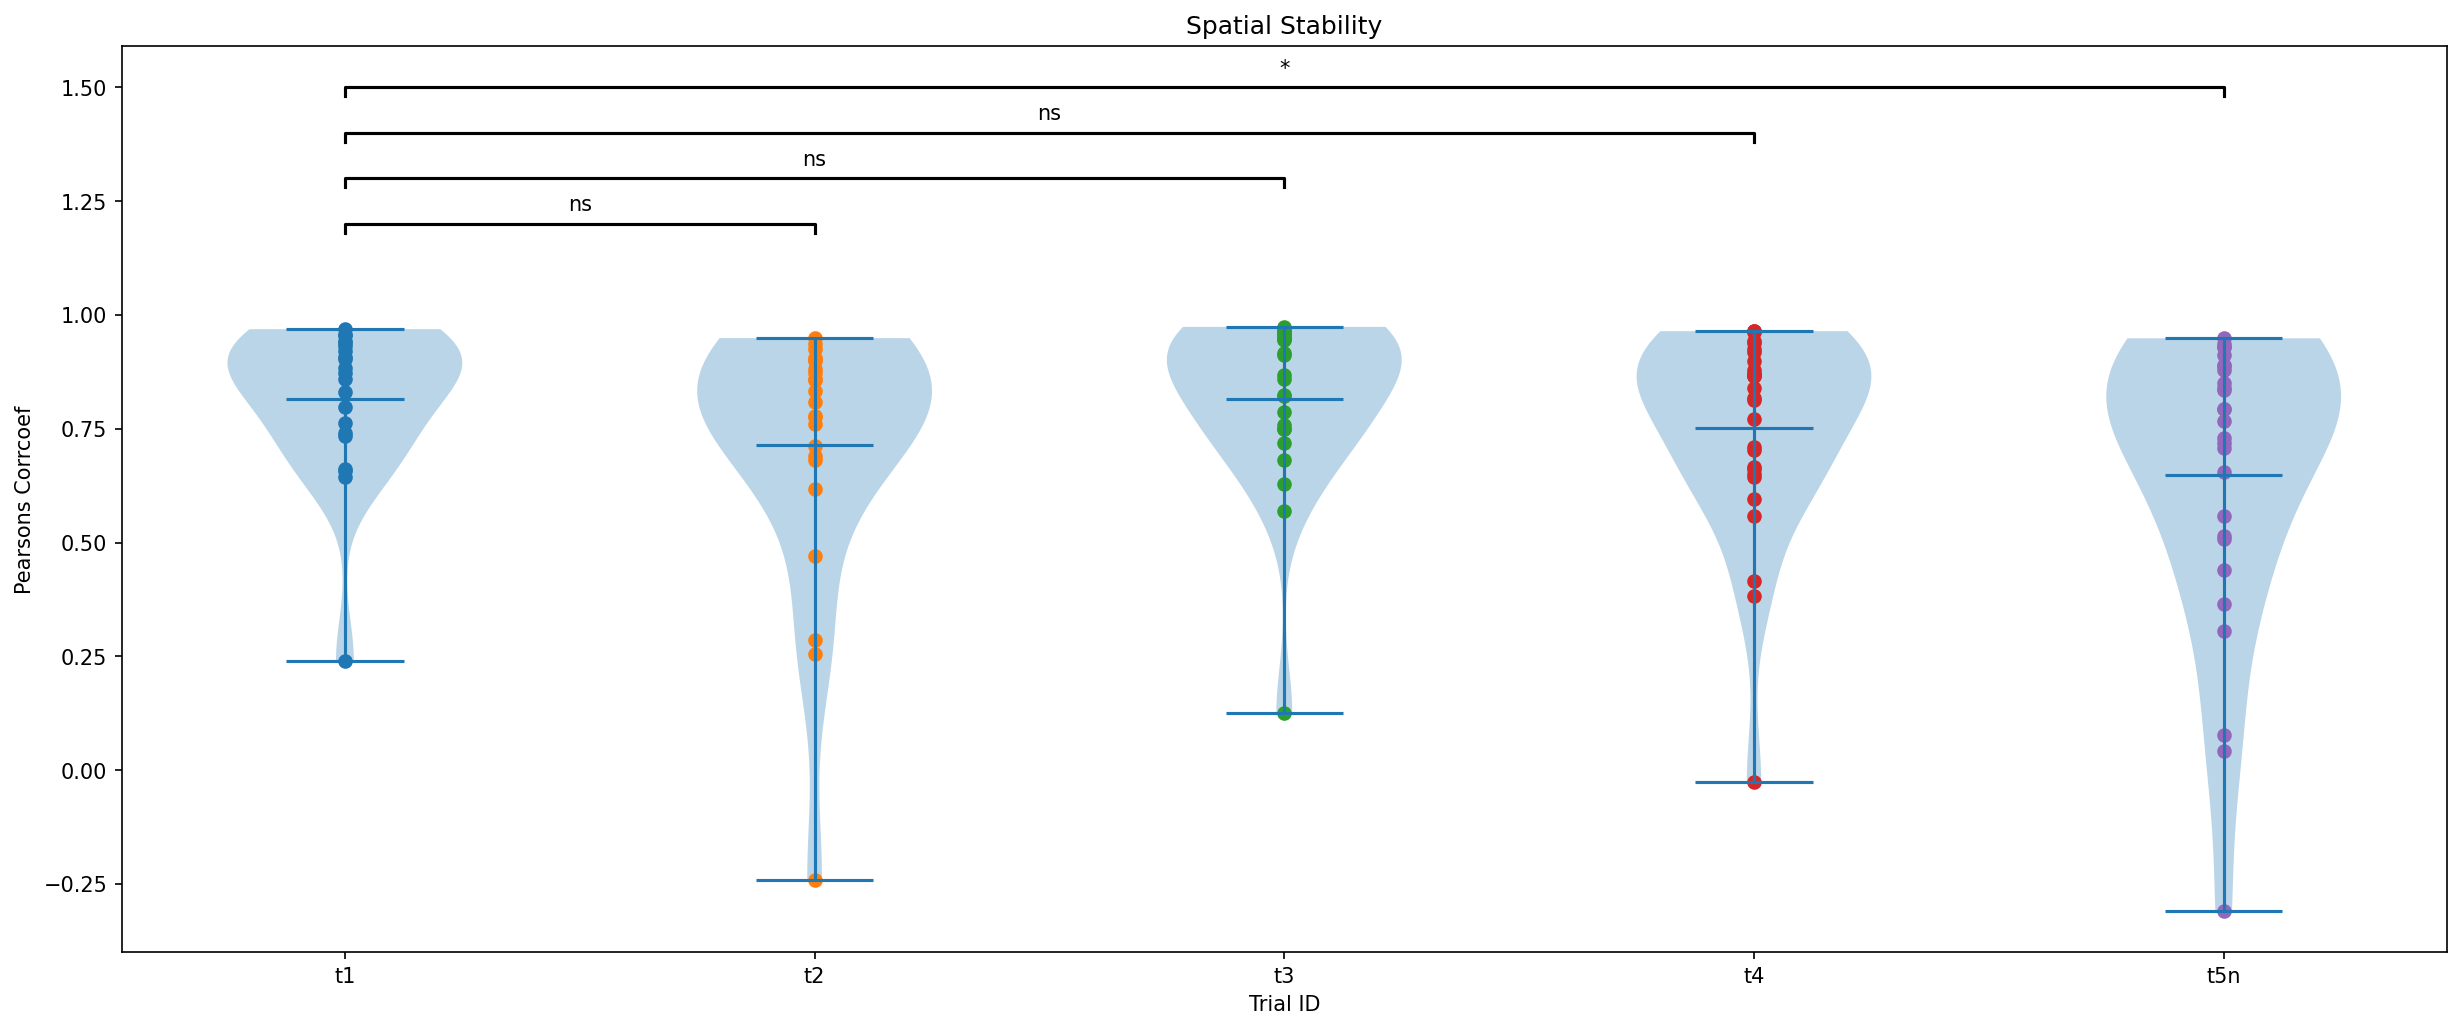

In [7]:
plt.rcParams.update({'figure.dpi': 150, 'legend.frameon': False})
# sns.set_style('white', {'legend.frameon': False})
palette = {'setosa': '#7fc97f', 'versicolor': '#beaed4', 'virginica': '#fdc086'}

fig, ax = plt.subplots(figsize=(20,8))
ax.violinplot(stability.values(), showmeans=True)
#plt.xticks(rotation=45)

# --- plot formatting ---
# add trial labels to x-axes ticks
labels = stability.keys()
ticks_locs = np.arange(1, len(labels) + 1)
ax.set_xticks(ticks_locs)
ax.set_xticklabels(labels)

# --- Plot data points in the violin ---
for xtick, correlations in zip(ticks_locs, stability.values()):
    ax.scatter(np.ones(len(correlations))*xtick, correlations)

# set axes and title labels
ax.set_title('Spatial Stability')
ax.set_ylabel('Pearsons Corrcoef')
ax.set_xlabel('Trial ID')

def plot_significance(pvalue, x = [0, 1], y=1.2, h=0.02):
    # significance
    if pvalue < 0.0001:
        significance = "****"
    elif pvalue < 0.001:
        significance = "***"
    elif pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = "ns"

    x1, x2 = x
    plt.plot([x1, x1, x2, x2], [y - h, y, y, y - h], c='k')
    plt.text((x1 + x2) / 2, y + h, significance, ha='center', va='bottom')

    
for i, t_id in enumerate(stability):
    if i == 0:
        baseline = t_id
        continue
        
    mw = scipy.stats.mannwhitneyu(stability[baseline], stability[t_id], alternative='two-sided')
    print(baseline + " vs " + t_id + ":", mw)
    plot_significance(mw.pvalue, [1,i+1], y = 1.1 + (i)*0.1)
    
#plt.savefig('./plots/inter-trial-spatial-stability.pdf')

c:\users\sarahht\programs\envs\expipe\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


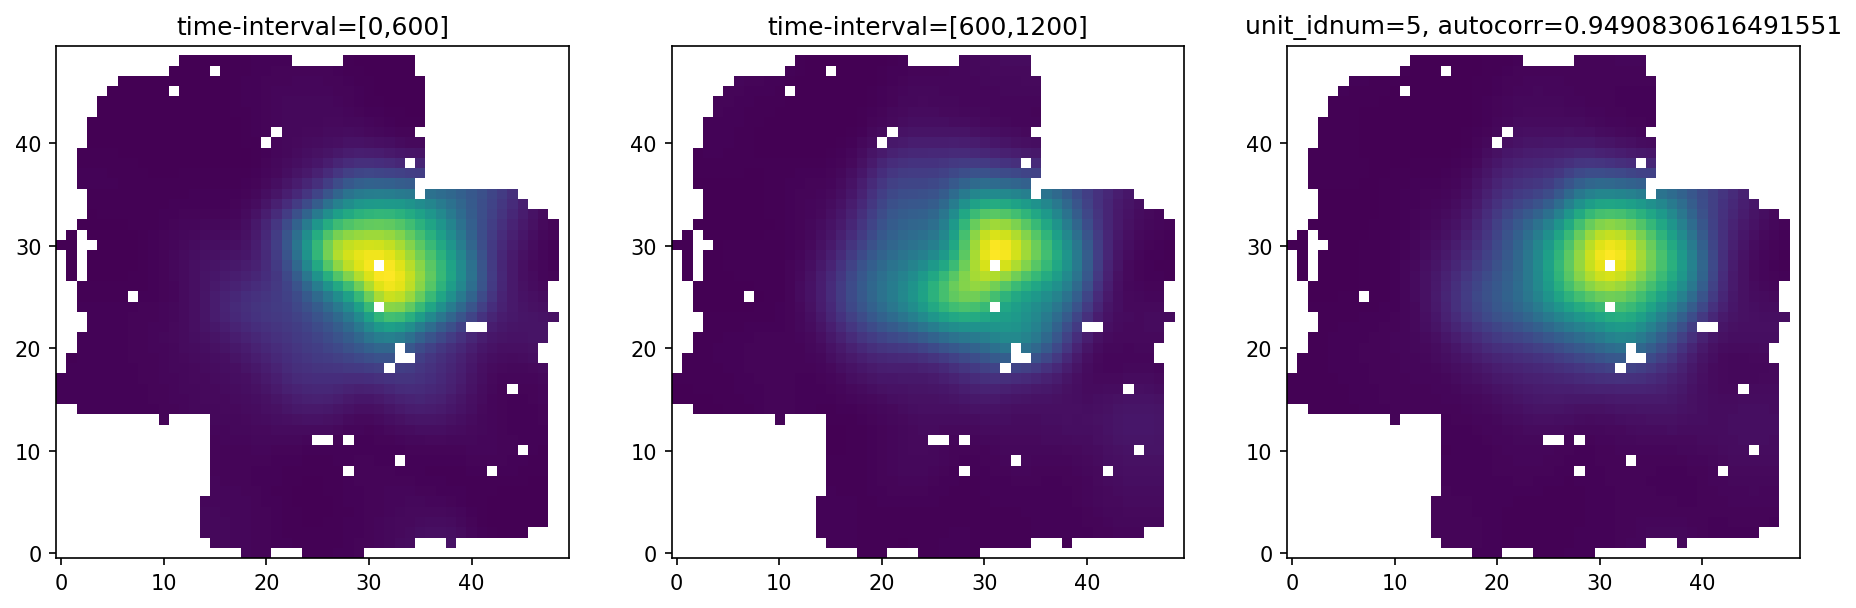

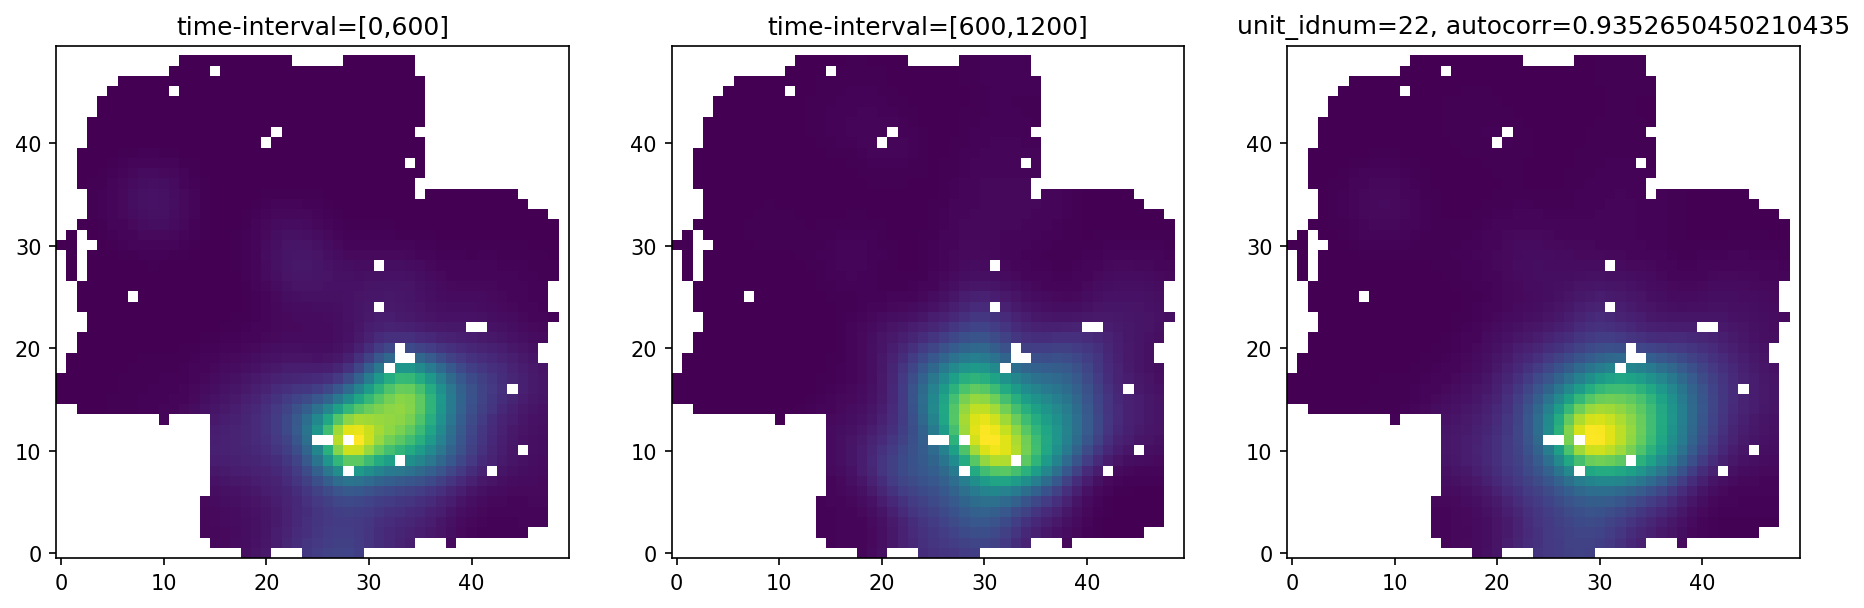

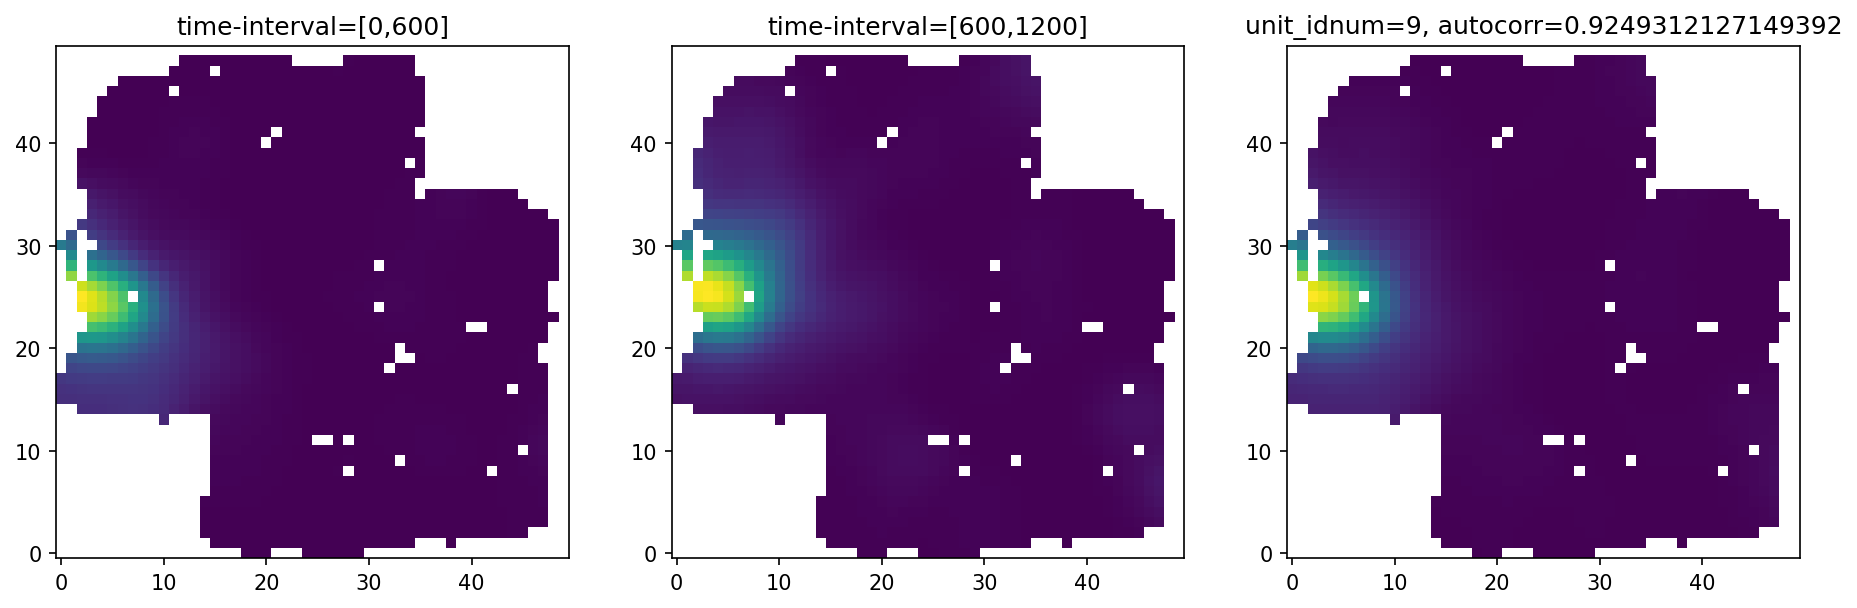

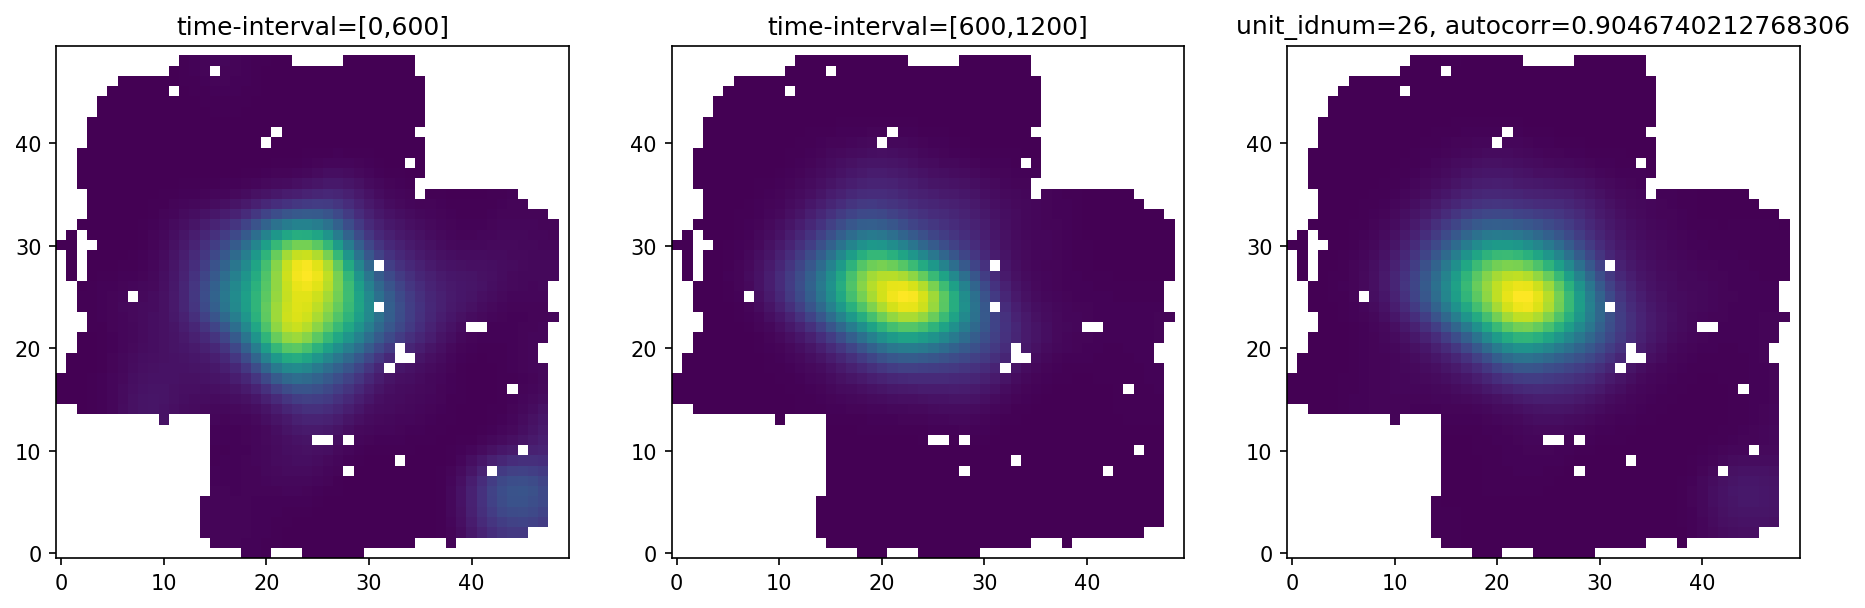

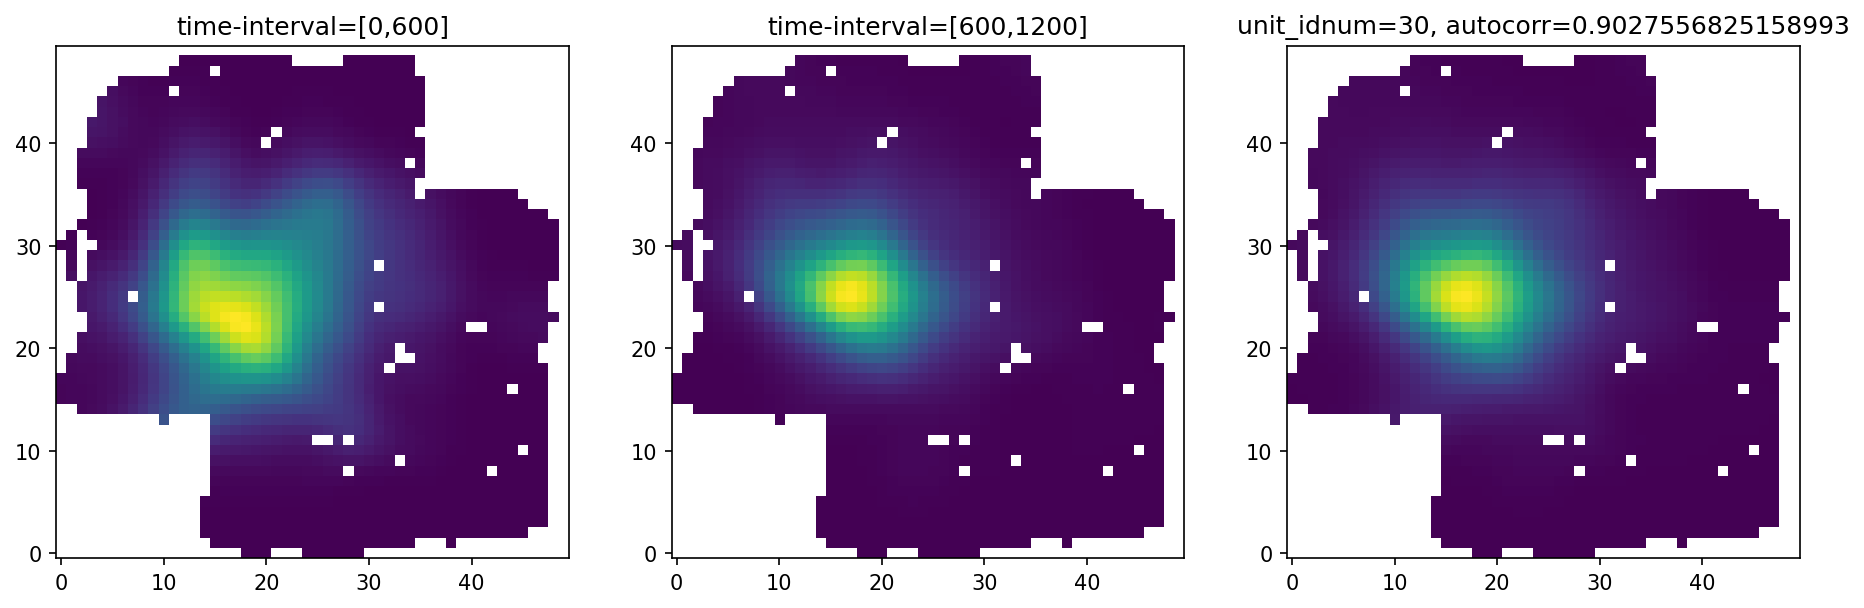

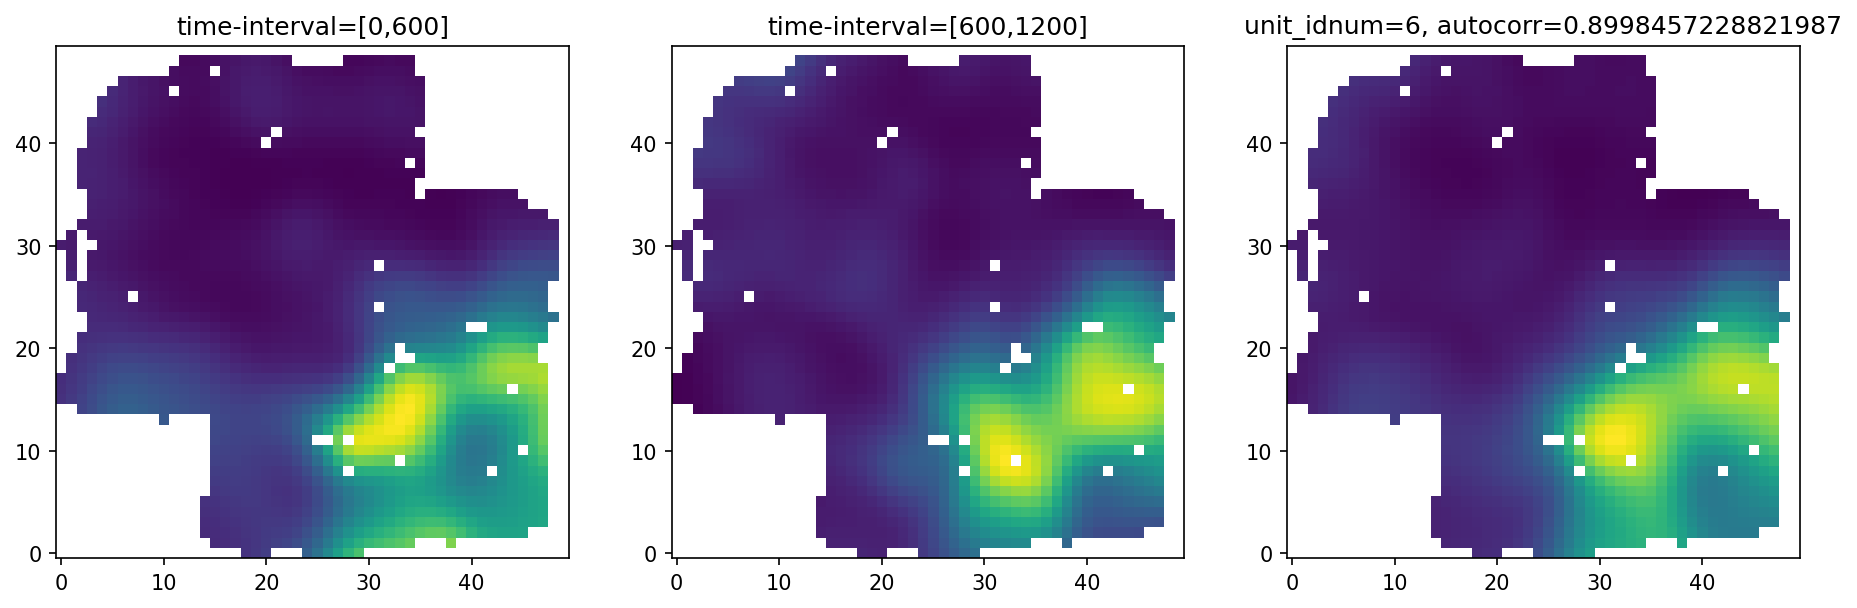

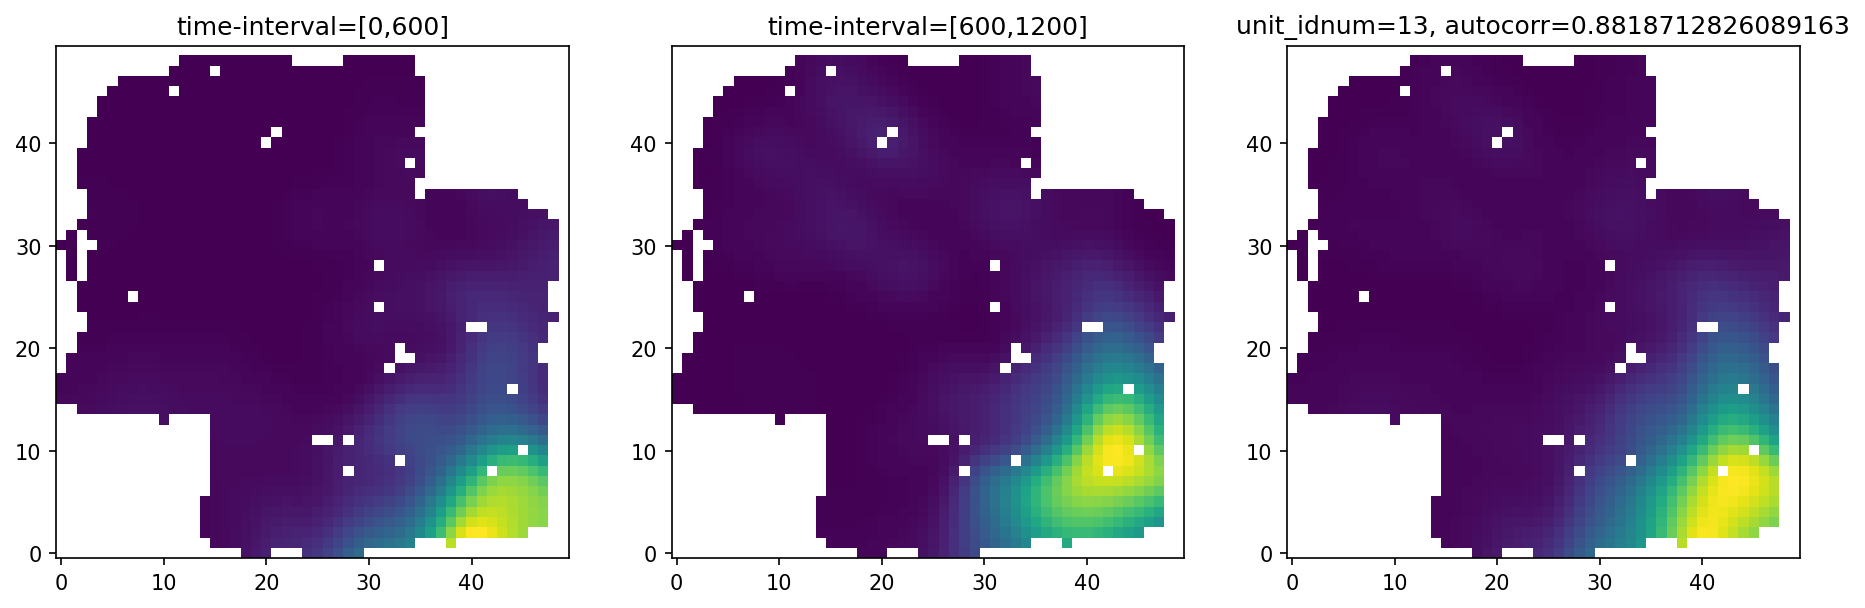

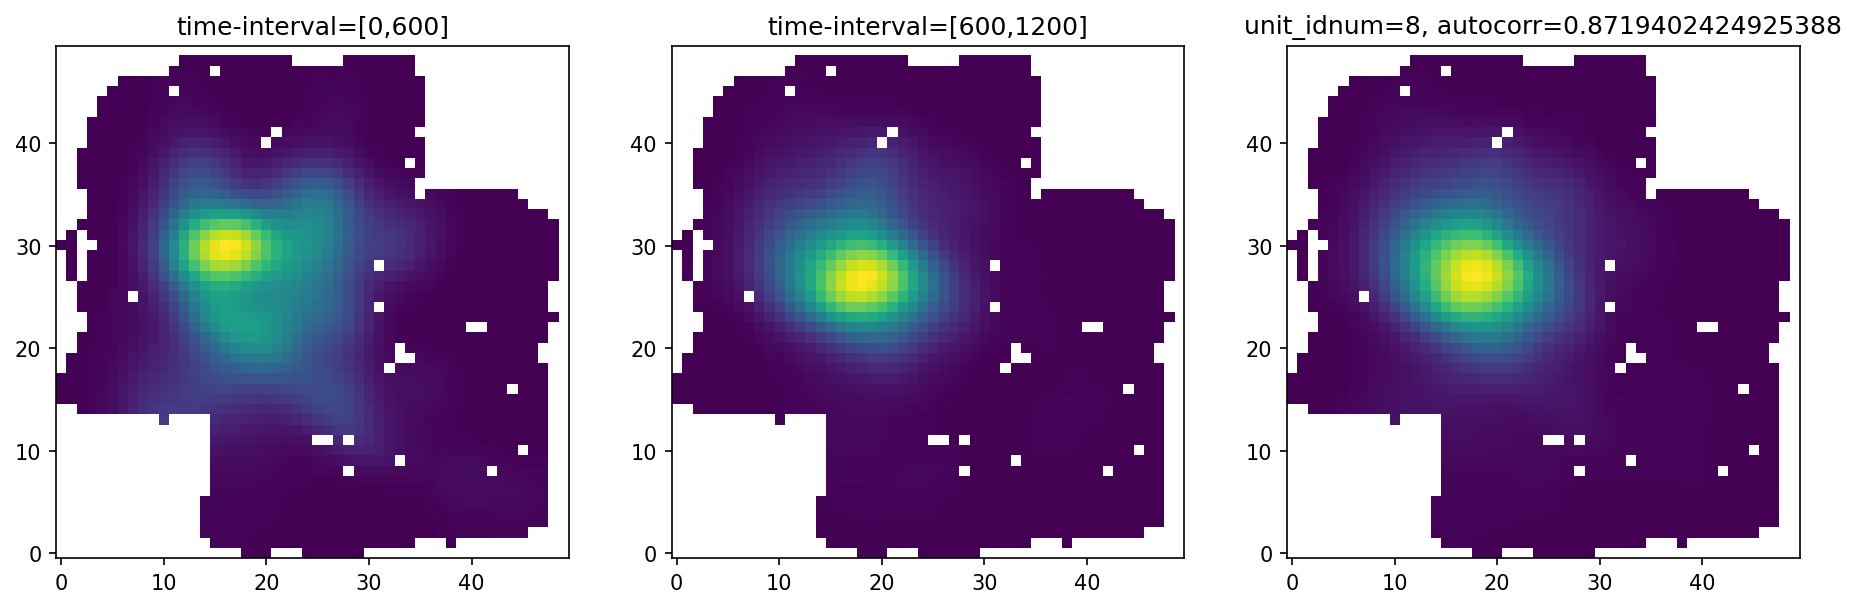

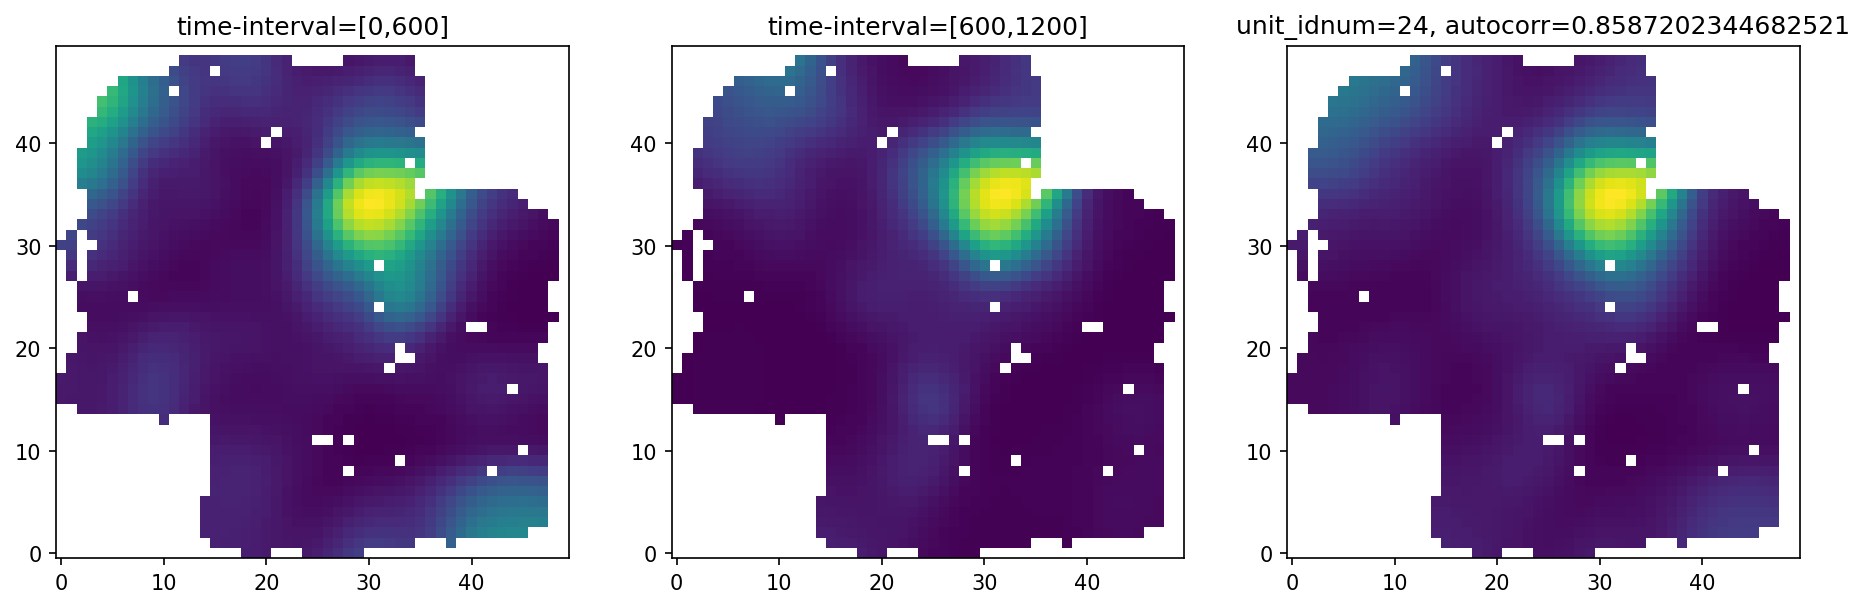

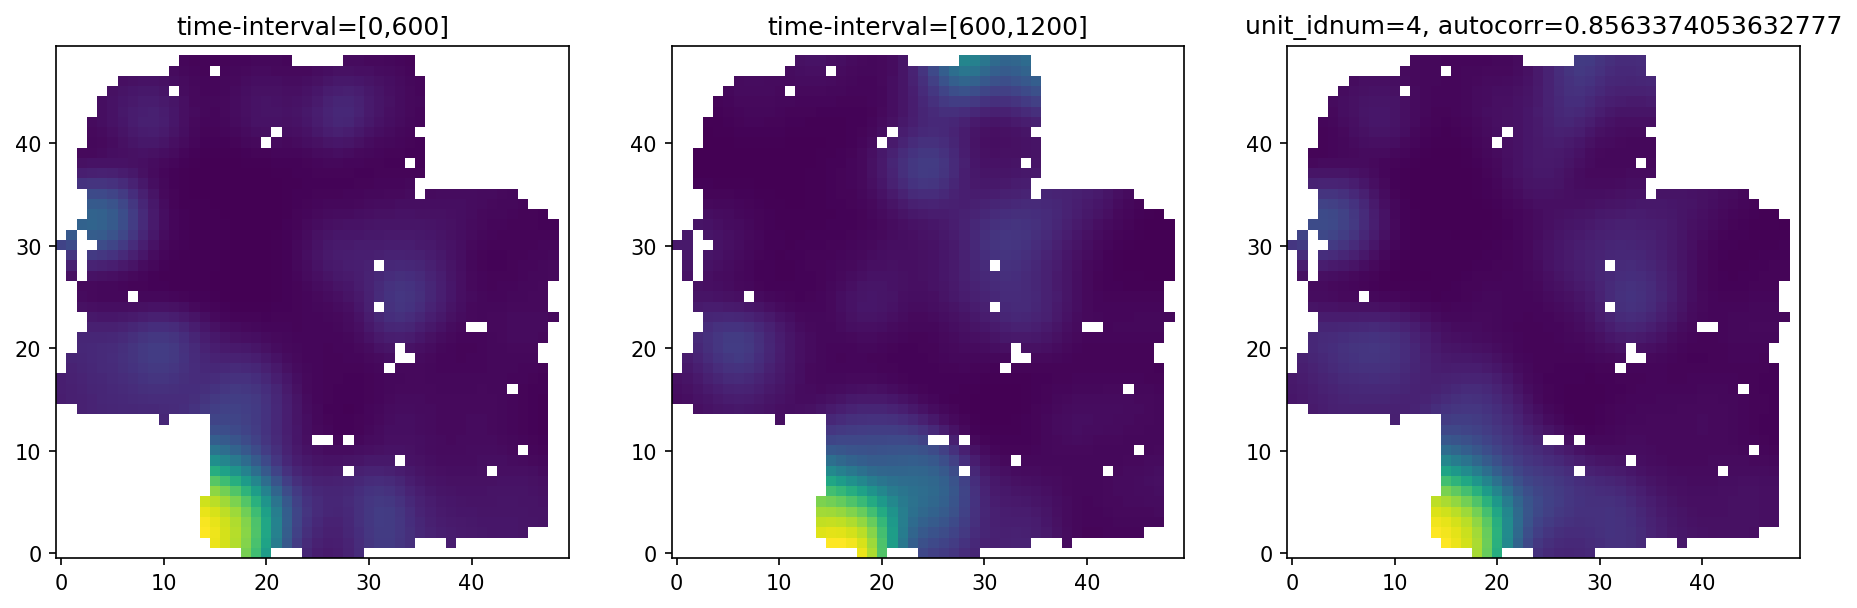

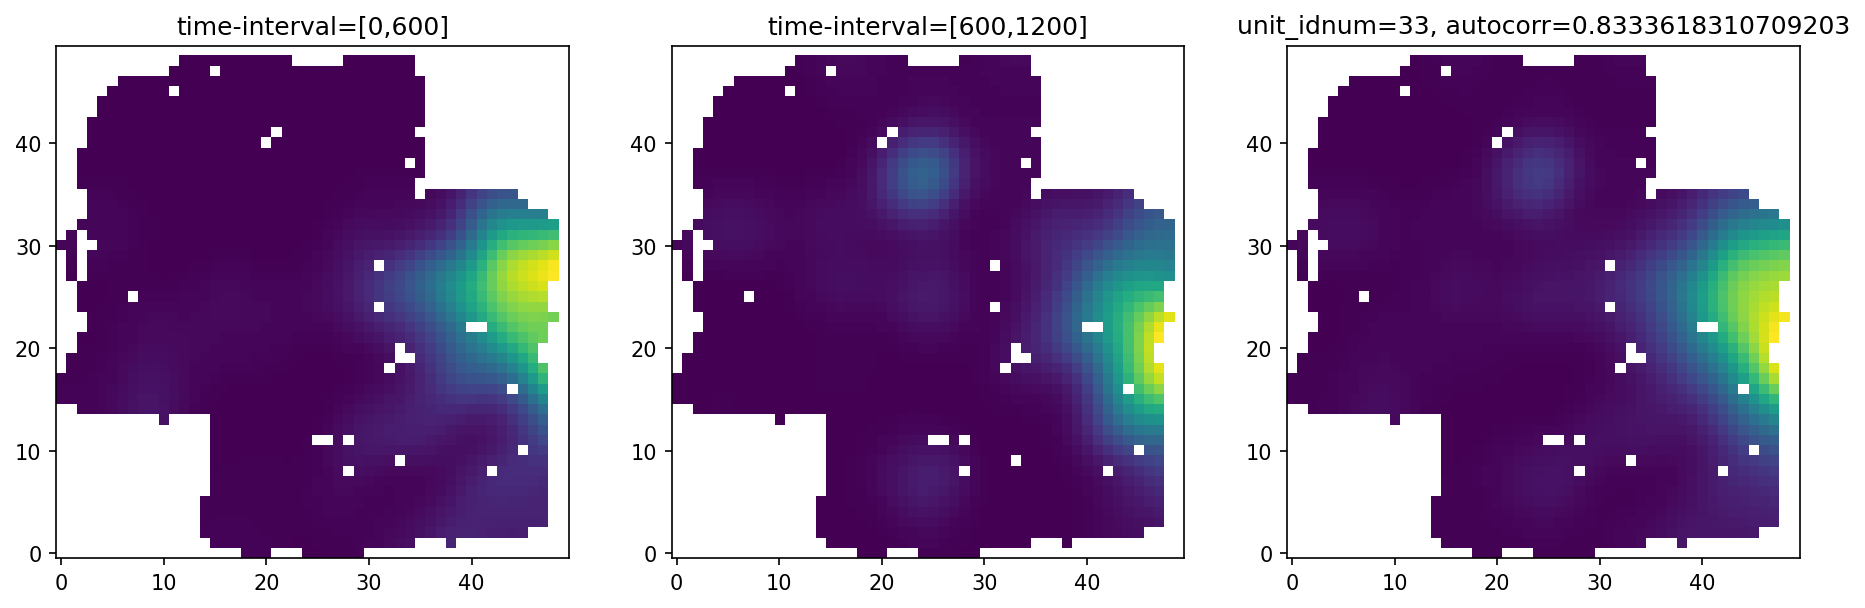

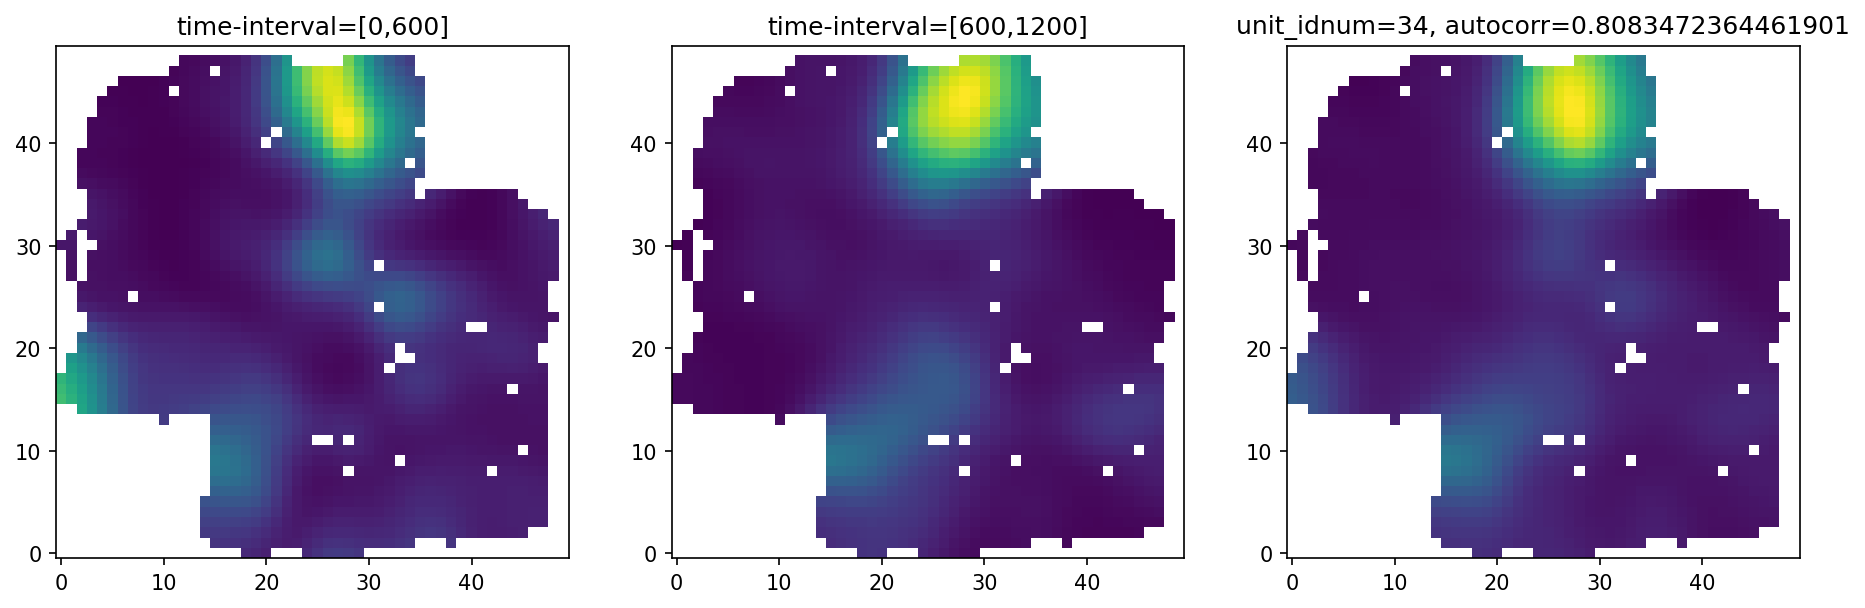

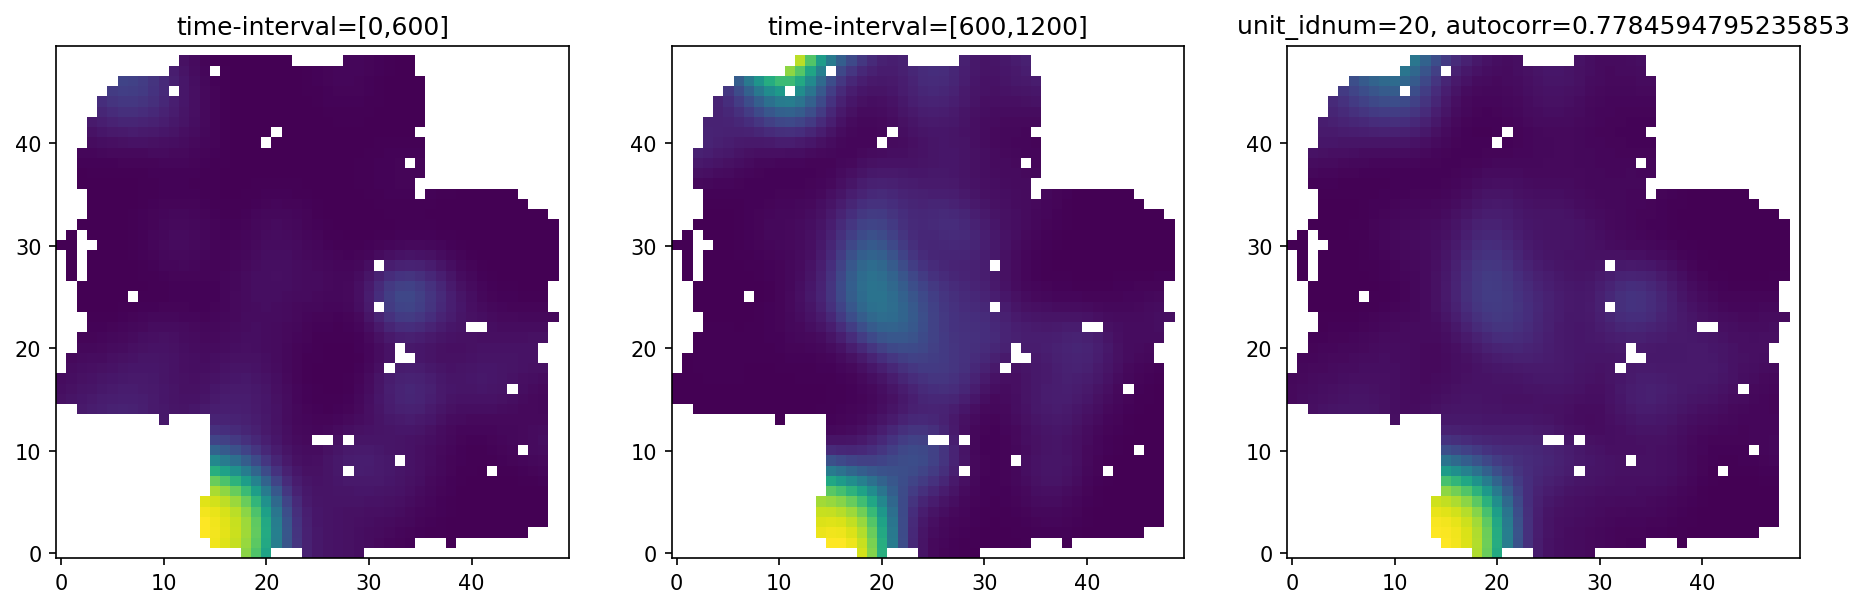

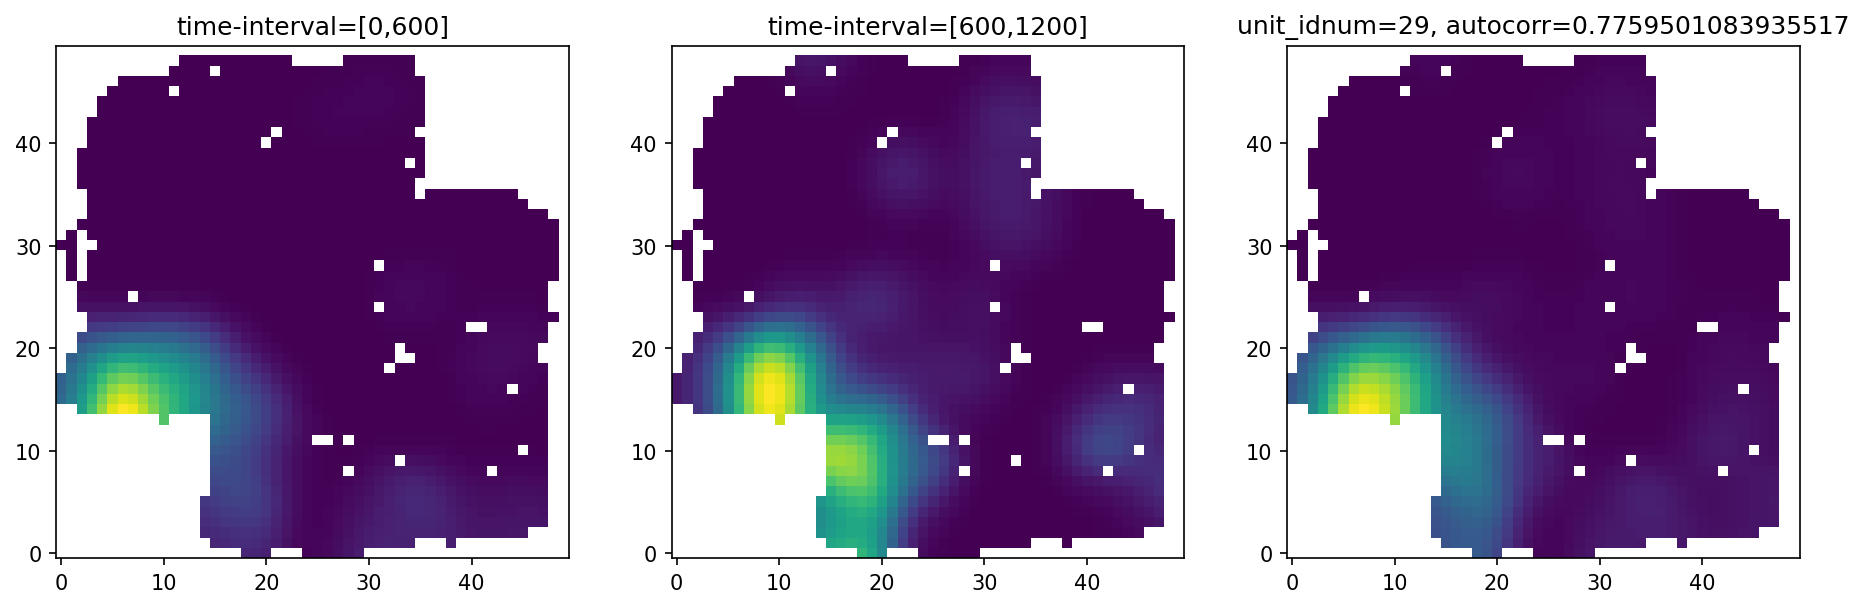

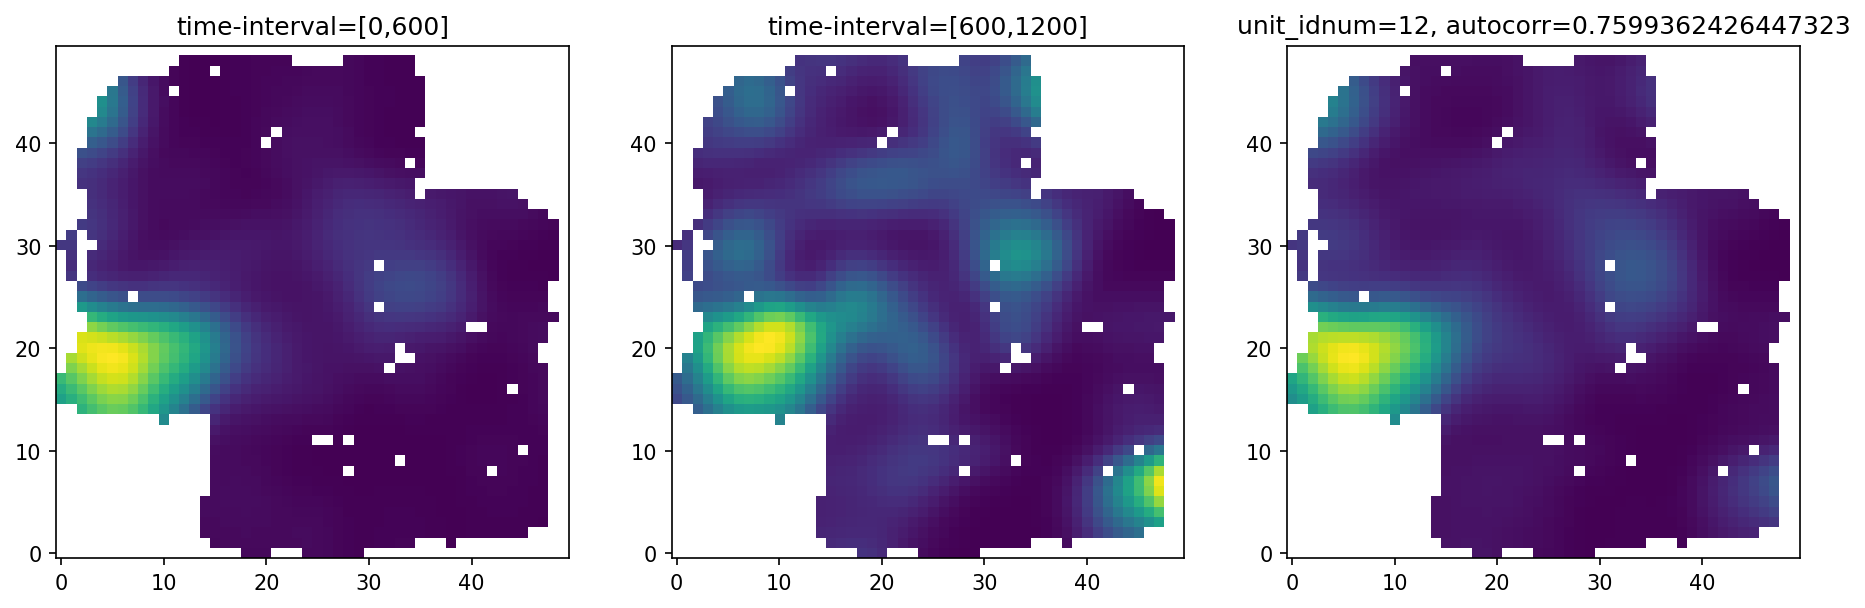

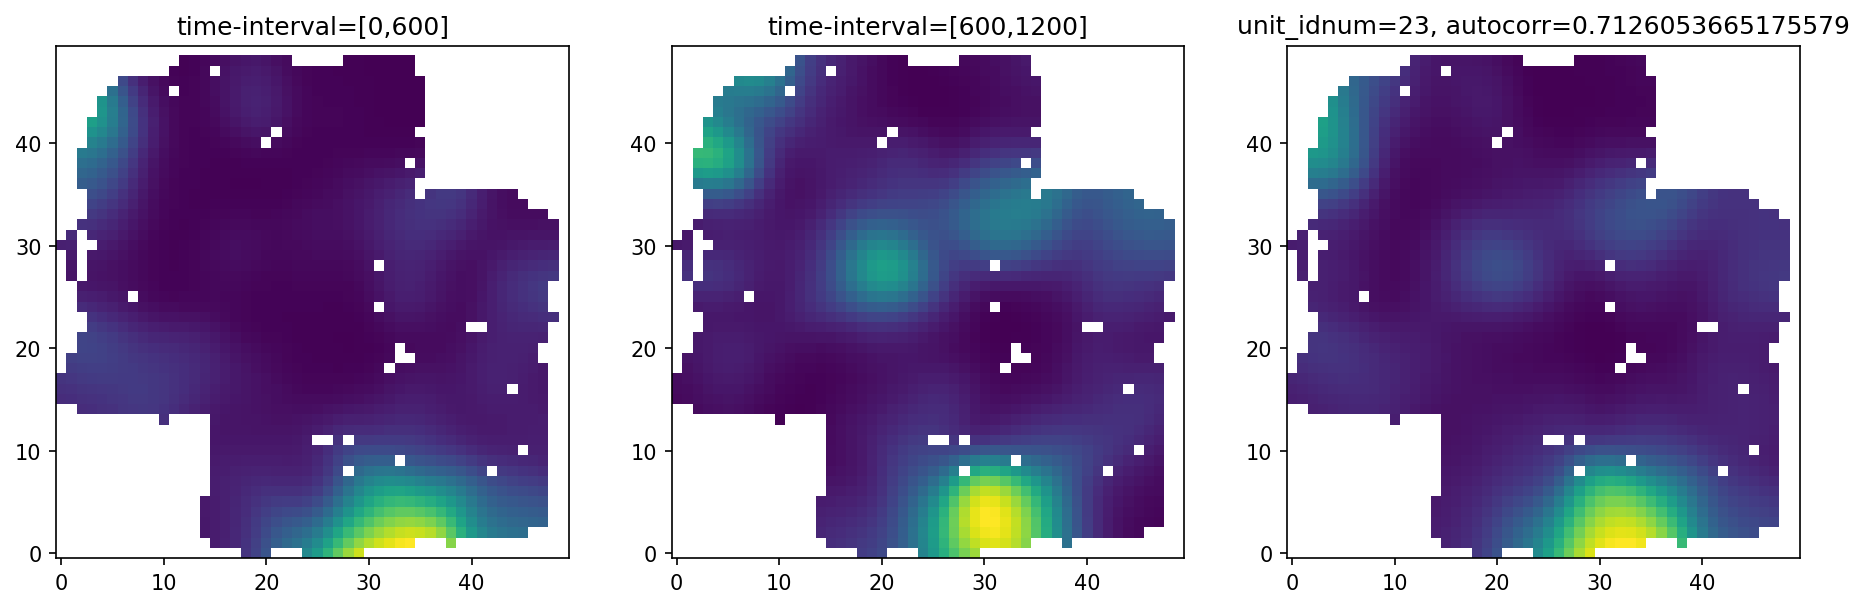

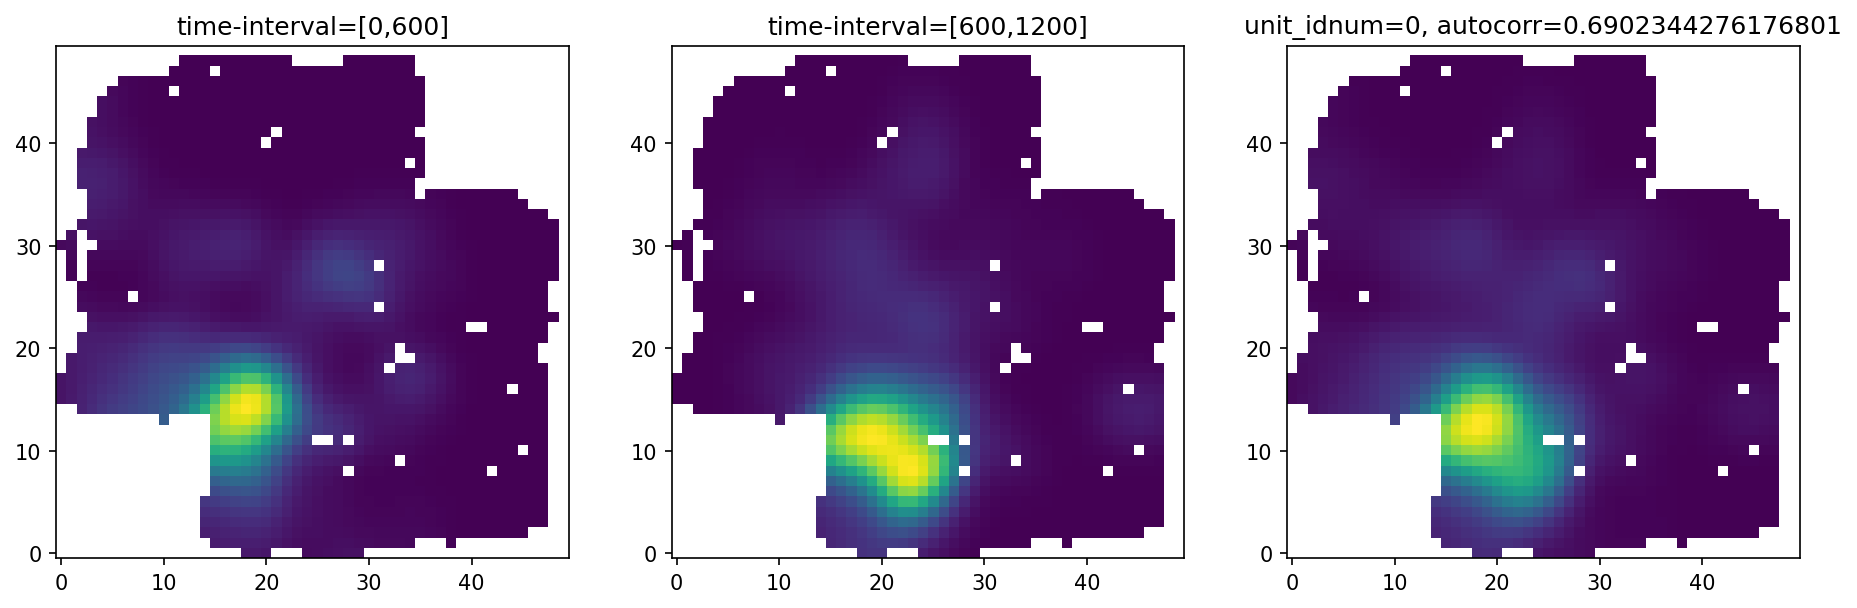

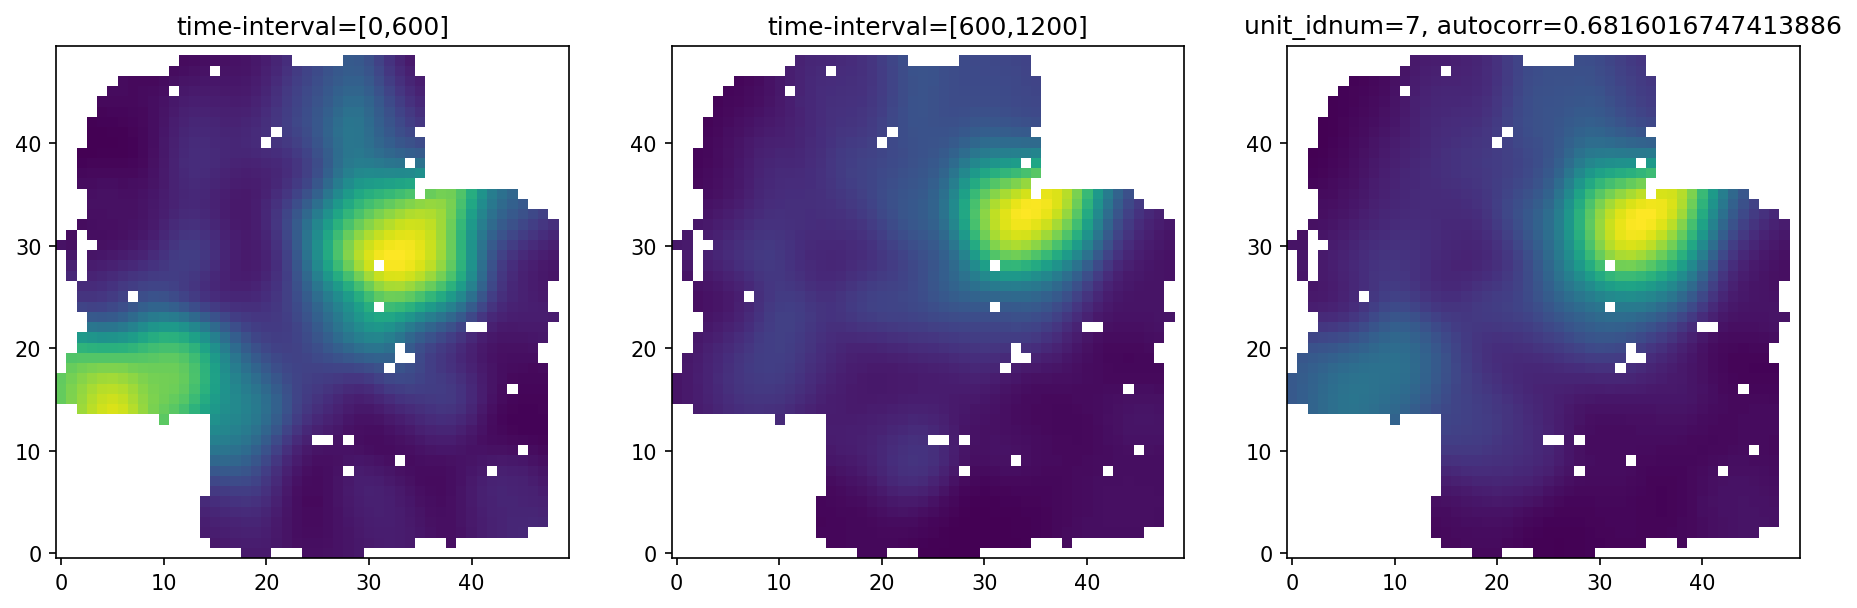

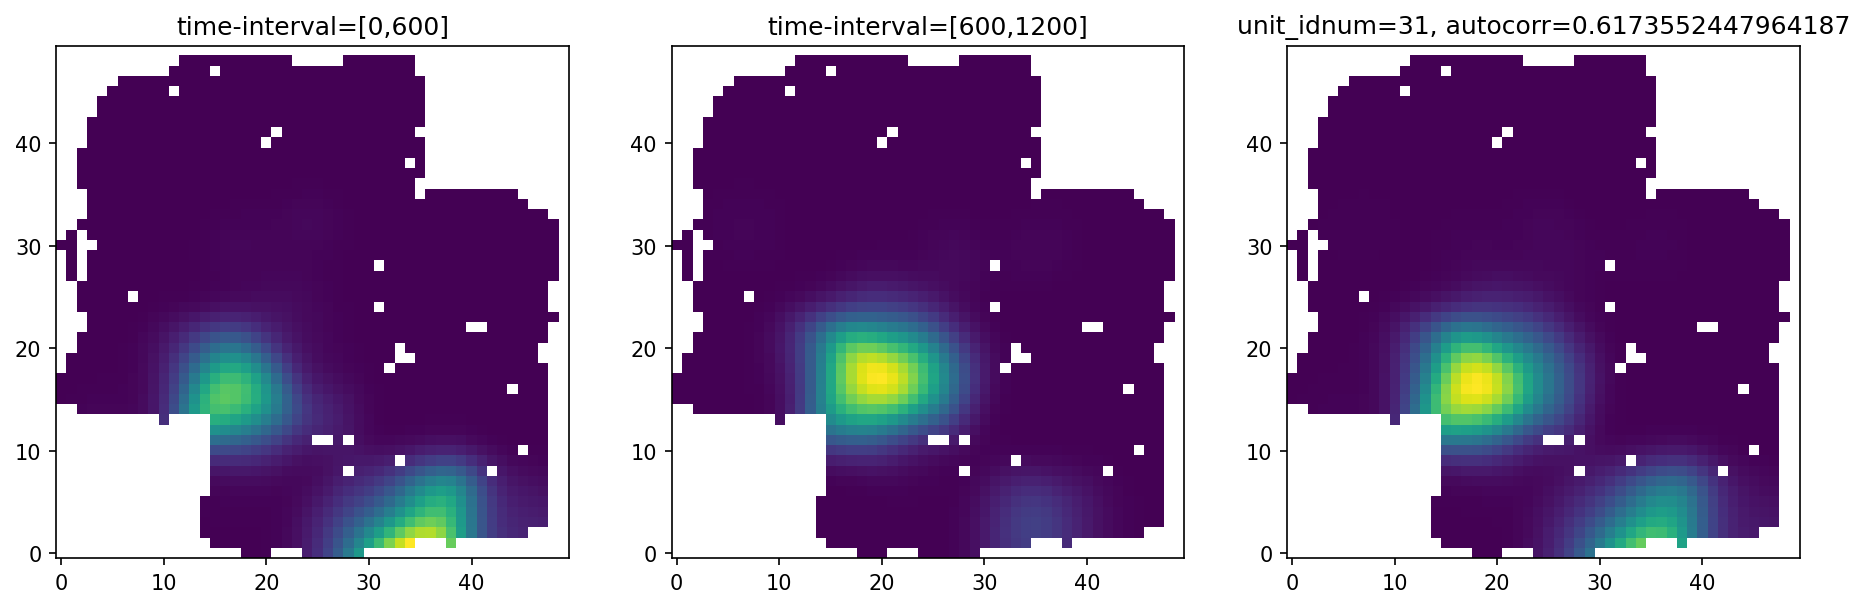

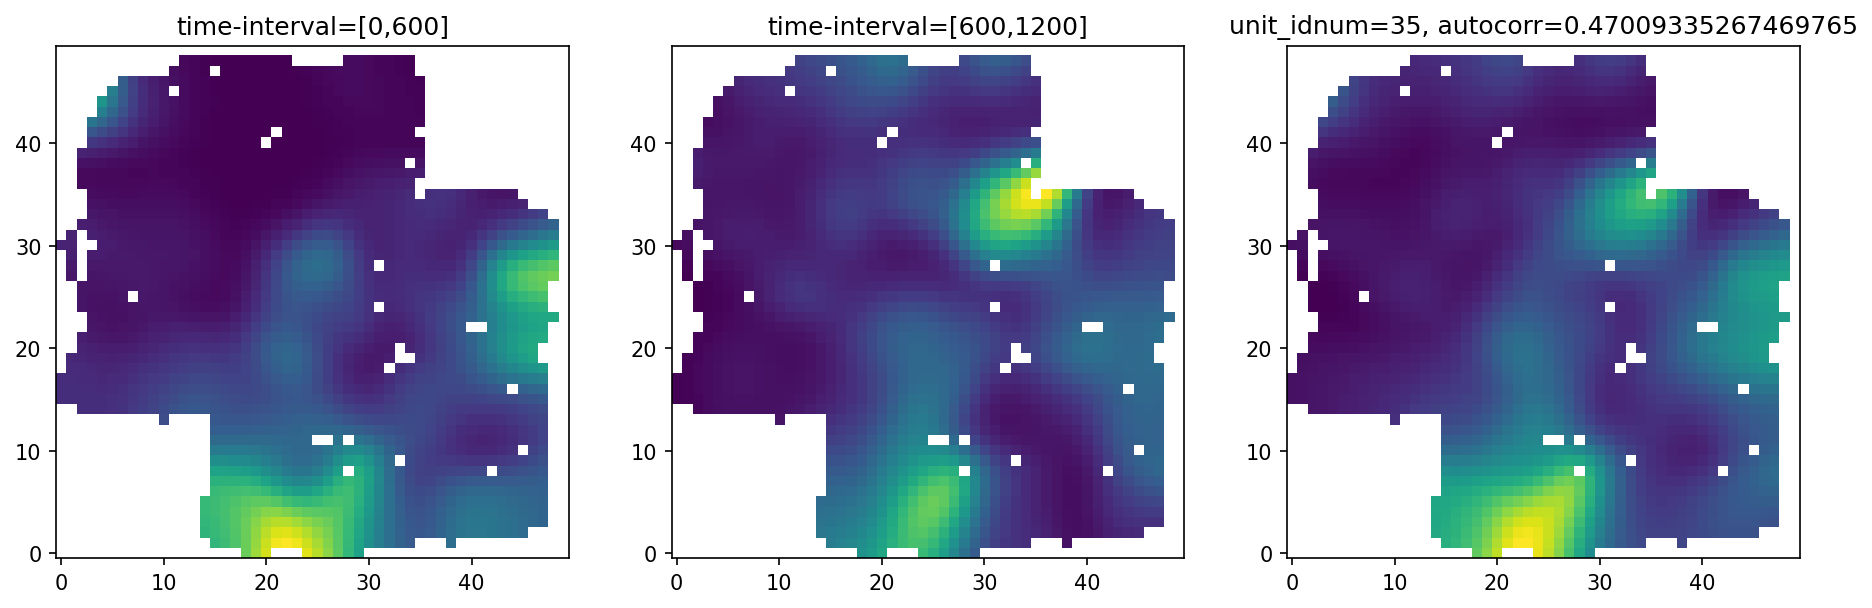

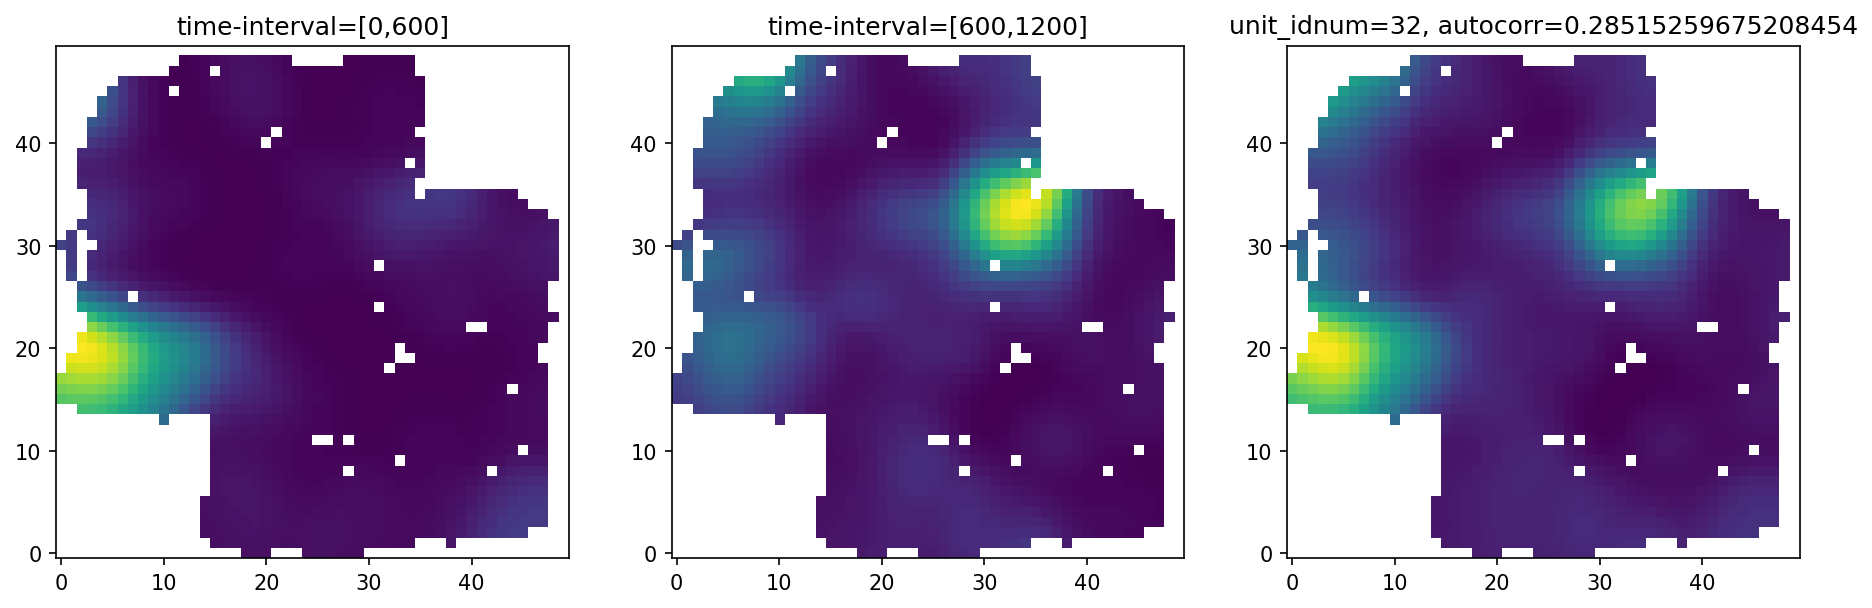

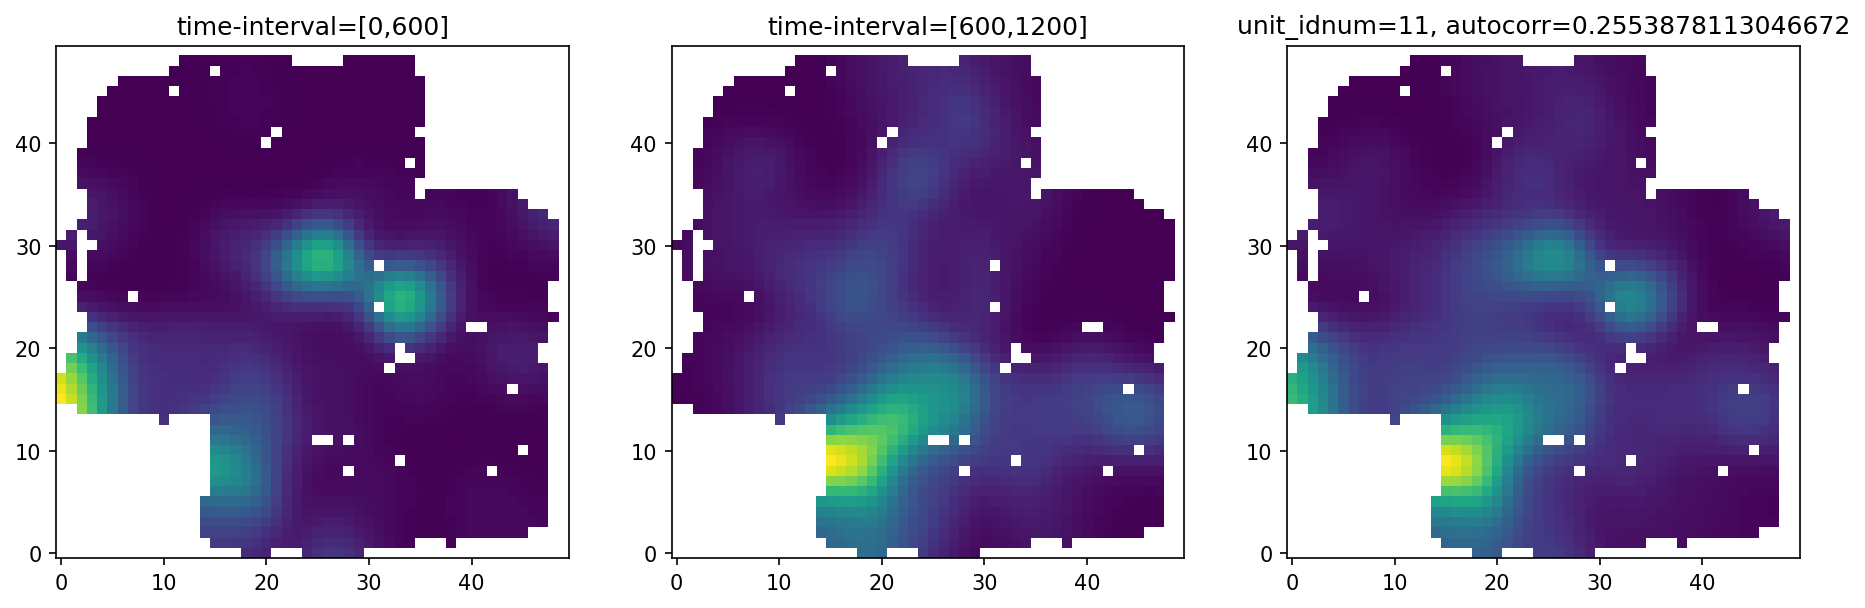

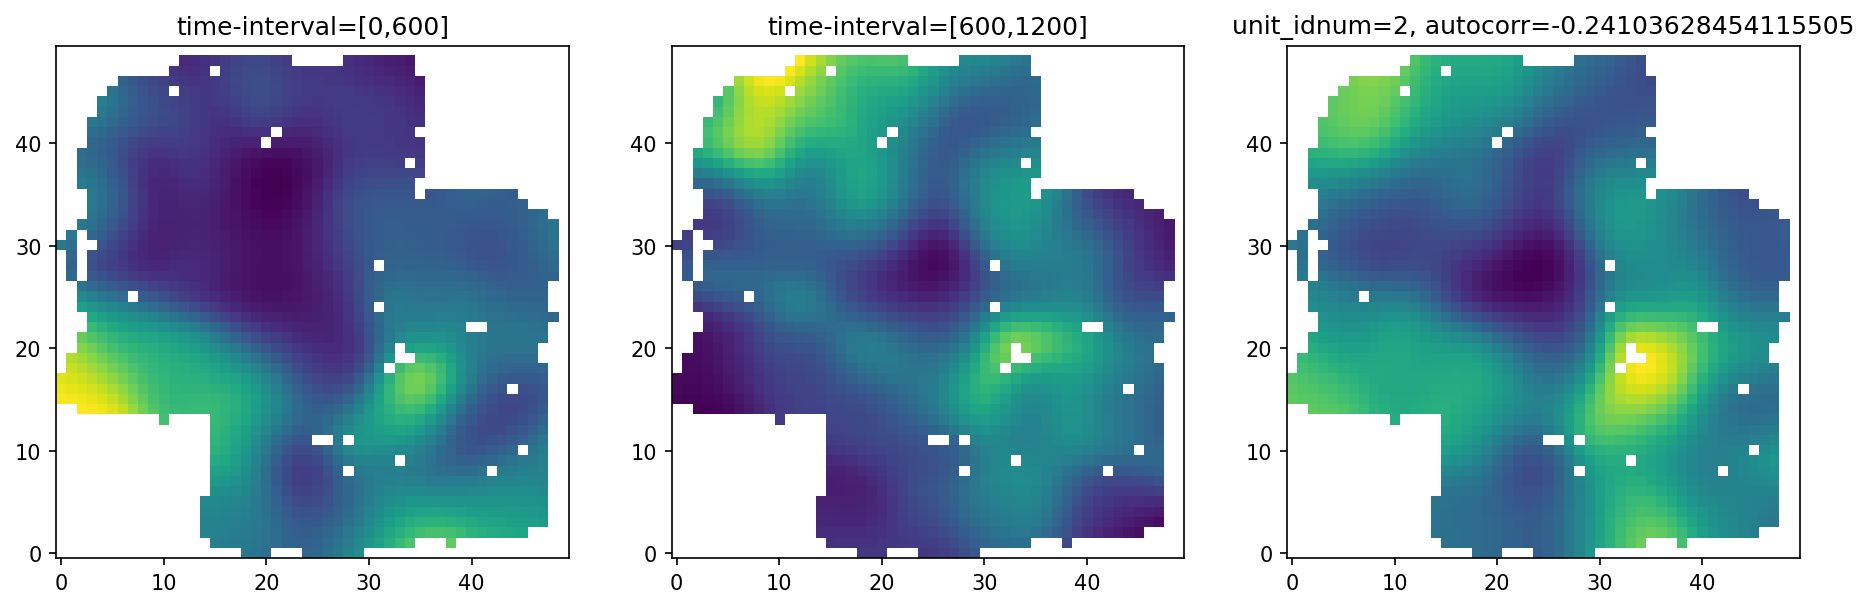

In [8]:
# choose trial to plot sorted ratemaps for
trial_id_choice = 't2'
trial_spikes = [spike_train for spike_train in spikes if spike_train.annotations["trial_id"] == trial_id_choice]
sort_idxs = np.argsort([spike_train.annotations["autocorr"] for spike_train in trial_spikes])[::-1]

for idx in sort_idxs:
    action_id = trial_spikes[idx].annotations["action_id"]
    ratemap1, ratemap2 = partial_ratemap_fn(tracking,trial_spikes[idx],t_mid)
    ratemap = spatial_map.rate_map(*tracking[action_id].T[:3],trial_spikes[idx])
    fig,axs = plt.subplots(ncols=3,figsize=(15,5))
    axs[0].imshow(ratemap1.T,origin='lower')
    axs[0].set_title(f"time-interval=[{lim[0]},{t_mid}]")
    axs[1].imshow(ratemap2.T,origin='lower')
    axs[1].set_title(f"time-interval=[{t_mid},{lim[1]}]")
    axs[2].imshow(ratemap.T,origin='lower')
    axs[2].set_title(f"unit_idnum={trial_spikes[idx].annotations['unit_idnum']}, autocorr={trial_spikes[idx].annotations['autocorr']}")